In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
import numpy as np
import diffprivlib  as dp
import matplotlib.pyplot as plt



### Estimating the Epsilon

##### Implementing the Econmic method from Hsu et al.
[J. Hsu et al., "Differential Privacy: An Economic Method for Choosing Epsilon," 2014 IEEE 27th Computer Security Foundations Symposium, Vienna, 2014, pp. 398-410.](https://arxiv.org/pdf/1402.3329.pdf)


https://www.cis.upenn.edu/~ahae/talks/epsilon-csf2014.pdf


<figure>
<img src="images/hsu-et-al-equation7.PNG" />
</figure>


<figure>
<img src="images/hsu-et-al-equation8.PNG"  />
</figure>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


B =10000#budget
alpha=0.02#probability
T=0.08#additive error  +- 8%
average_breach_chance=0.08
average_breach_cost_US=429
E_Patient_Expected_US=average_breach_cost_US*average_breach_chance
study_feasable_func = lambda E: np.log( 1+ ((B*pow(T,2))/(12*E*np.log(3/alpha))) )-(T/6)
initial_guess = 0.01
E_feasiable = fsolve(study_feasable_func, initial_guess)

print('Particpants\' belief on the average cost even if they dont attend: '+str(E_Patient_Expected_US))
print ('Feasiable cost per particpant based on our budget: '+str(E_feasiable))
print('Is it feasible?'+str(E_feasiable>E_Patient_Expected_US))

Particpants' belief on the average cost even if they dont attend: 34.32
Feasiable cost per particpant based on our budget: [79.29917783]
Is it feasible?[ True]


In [4]:
N=(12/pow(T,2))*np.log(3/alpha)
print('Number of particpants: '+str(int(N+0.5)))


Number of particpants: 9395


In [5]:
total_epsilon_budget=T/6
print ('Epsilon Value: '+ str(total_epsilon_budget))

Epsilon Value: 0.013333333333333334


In [6]:
# total_epsilon_budget=0.1

### Load and Preprocess Data

In [7]:
ecg_file_input_path='/Users/aring/jupyter/differential-privacy/data/Arno/Diagnostics.xlsx'
ecg_df=pd.read_excel(ecg_file_input_path)
ecg_df.head()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,01-01-1932,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,01-01-1958,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,01-01-1996,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,01-01-1951,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,01-01-1943,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [8]:
Y_df=ecg_df['Rhythm']


In [81]:
arrhytmia_types=Y_df.unique()
arrhytmia_types

array(['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT',
       'SAAWR', 'AVRT'], dtype=object)

### Train Classifier

In [10]:
from sklearn import preprocessing

labelEncoder = preprocessing.LabelEncoder();
encoded_y=labelEncoder.fit_transform(Y_df)

In [11]:
ecg_df.drop(['DateofBirth'], axis=1,inplace=True)
ecg_df.drop(['Beat'], axis=1,inplace=True)
ecg_df.drop(['FileName'], axis=1,inplace=True)
ecg_df.drop(['Rhythm'], axis=1,inplace=True)


In [12]:
ecg_df['Gender_encoded']=ecg_df['Gender'].map({'MALE':0,'FEMALE':1})


In [13]:
gender_df=ecg_df['Gender_encoded']
ecg_df.drop(['Gender'], axis=1,inplace=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(ecg_df, encoded_y, test_size=0.2)

In [15]:
from diffprivlib.models import GaussianNB

clf = GaussianNB(epsilon=1)
clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/diffprivlib/models/naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)


GaussianNB(accountant=BudgetAccountant(spent_budget=[(1, 0)]),
           bounds=(array([  4.,  34.,   0.,  52., 114., 219., -89., -89.,   5., 159., 249.,
       281.,   0.]),
                   array([ 98., 263., 535., 234., 736., 760., 270., 270.,  40., 235., 331.,
       582.,   1.])),
           epsilon=1)

In [16]:
pred=clf.predict(X_test[1:100])


In [17]:
print(y_test[1:100])

[ 7  9 10  9  8  0  7  9  8  7  5  1  2  7 10  7  7  8  9  5  7  5  0  1
  7  0  1  1  7  8  7  1  1  2  1  1  1  7  8  7  7 10  7  7  8  1  8  9
  7  7  7  1  7  9  8  5  8  8  9  8  8  7  0  7  7  8  5  7  0 10  0  8
  1 10  8  1  1  8 10  8  7  9  7  5  0  7  7  7  2  8  7  7  8  1  7  5
  7  9  2]


In [18]:
clf.score(X_test, y_test)

0.5427230046948357

In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7408450704225352

### changing epsilon

In [20]:
col_names=ecg_df.columns
ranges_min=[]
ranges_max=[]
for i in range(len(col_names)):
    ranges_min.append(ecg_df[ecg_df.columns[i]].min())
    ranges_max.append(ecg_df[ecg_df.columns[i]].max())

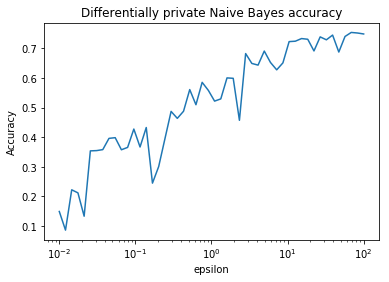

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB

epsilons = np.logspace(-2, 2, 50)
bounds = (ranges_min,ranges_max )
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(bounds=bounds, epsilon=epsilon)
    clf.fit(X_train, y_train)
    
    accuracy.append(clf.score(X_test, y_test))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

### Age Distributoin Histograms


In [22]:
ages=ecg_df['PatientAge']
hist, bins = np.histogram(ages)
hist = hist / hist.sum()

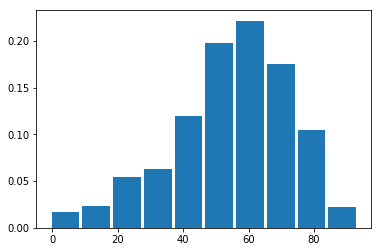

In [23]:

plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

We know from the dataset description that everyone in the dataset is between 4-98 years. WE should set the range tto the general bound of this attribute. we'll set the upper bound to 100, As of 2019, less than 0.005% of the world's population is aged over 100. Values above 100 will be excluded from calculations.

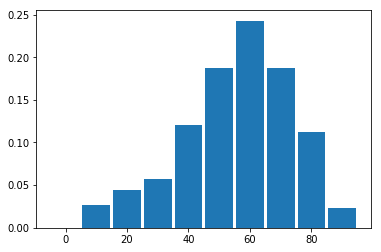

In [24]:
dp_hist, dp_bins = dp.tools.histogram(ages, epsilon=0.01, range=(0, 100))
dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.show()

In [25]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 0.089507


In [26]:
np.all(dp_bins == bins)


False

#### Gender Distribution

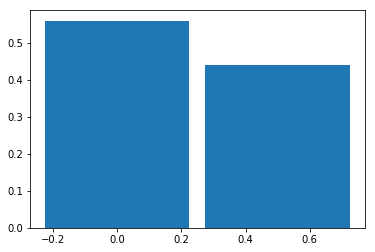

In [27]:

hist, bins = np.histogram(gender_df,bins=2)
hist = hist / hist.sum()
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

/anaconda3/lib/python3.7/site-packages/diffprivlib/tools/histograms.py:132: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  "specified independently of the data (i.e., using domain knowledge).", PrivacyLeakWarning)


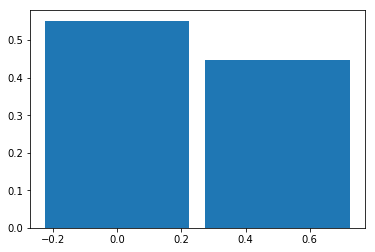

In [28]:
dp_hist, dp_bins = dp.tools.histogram(gender_df, epsilon=0.01,bins=2)
dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.show()

In [29]:
np.all(dp_bins == bins)


True

In [30]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 0.015586


### Finding the range of the values

In [31]:
col_names=ecg_df.columns
ranges=[]
for i in range(len(col_names)):
    ranges.append((ecg_df[ecg_df.columns[i]].min(),ecg_df[ecg_df.columns[i]].max()))

In [32]:
col_names

Index(['PatientAge', 'VentricularRate', 'AtrialRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset',
       'QOffset', 'TOffset', 'Gender_encoded'],
      dtype='object')

In [33]:
VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2



In [34]:
ranges

[(4, 98),
 (34, 263),
 (0, 535),
 (18, 256),
 (114, 736),
 (219, 760),
 (-89, 270),
 (-89, 270),
 (5, 40),
 (159, 240),
 (249, 331),
 (281, 582),
 (0, 1)]

#### Distribution of variables

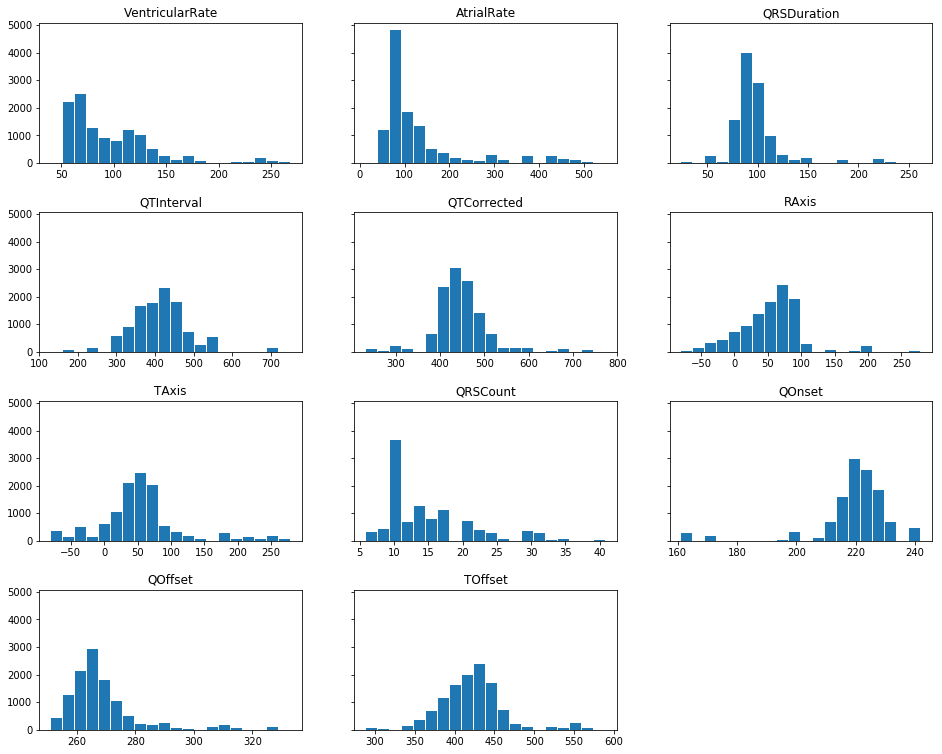

In [35]:
# ecg_df_no_gender=ecg_df.drop(['Rhythm'], axis=1)
col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = dp.tools.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range, epsilon=0.01)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])
plt.show()

##### actuals

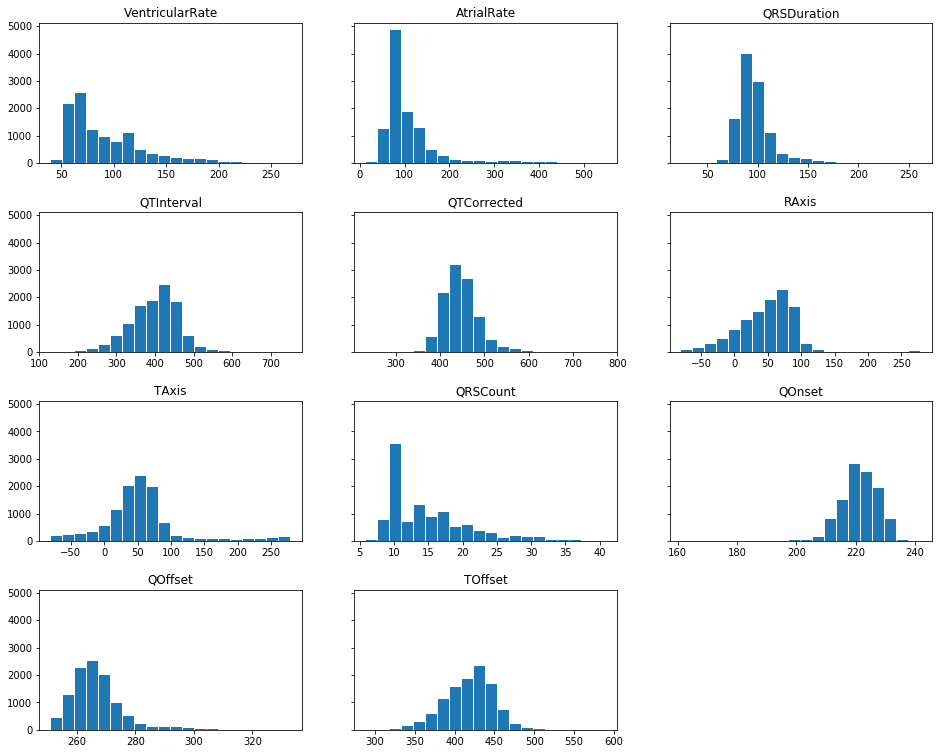

In [36]:
col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = np.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])

plt.show()

## Publishing A Differntially Private Report 

### Allocating the Privacy Budget

In [37]:
total_epsilon_budget=0.08

acc = dp.BudgetAccountant(total_epsilon_budget, 0)
acc.set_default()

eps_unit=total_epsilon_budget/8


VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [38]:
eps_unit

0.01

### QRS Duration gender differences

In [39]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


94.83304493137993

In [40]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


84.85012274570464

#### Actuals

In [41]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index])


95.16218938885157

In [42]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index])


85.68997867803839

### Ventricular rate Duration gender differences

In [43]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


81.30974223699106

In [44]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


85.36936332082178

#### Actuals

In [45]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index])


81.26108126259234

In [46]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index])


87.78720682302772

### QTInterval  Duration gender differences

In [47]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


388.8342912686874

In [48]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


356.95663996372747

#### Actuals

In [49]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index])


386.42209536601746

In [50]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index])


381.26652452025587

In [51]:
acc.remaining()

(epsilon=4.440892098500626e-18, delta=0.0)

In [52]:
acc.total

<bound method BudgetAccountant.total of BudgetAccountant(epsilon=0.08, delta=0, spent_budget=[(0.02, 0), (0.02, 0), (0.01, 0), (0.01, 0), (0.01, 0), ...])>

In [53]:
ranges[QTInterval_index]

(114, 736)

### QRS duration changes in Arrhythmias


In [95]:
total_epsilon_budget=0.11

acc = dp.BudgetAccountant(total_epsilon_budget, 0)
acc.set_default()

eps_unit=total_epsilon_budget/11


VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [96]:
eps_unit

0.01

In [97]:
for arrhytmia in arrhytmia_types:
    print(arrhytmia)
    print('actual: '+str(np.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])))
    print('dp: '+str (dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))

    

AFIB
actual: 92.78089887640449
dp: 90.82661716121389
SB
actual: 93.31807662638211
dp: 103.5866663120729
SA
actual: 87.45363408521304
dp: 18.0
AF
actual: 97.29887640449438
dp: 106.30366929888093
SR
actual: 87.00438116100767
dp: 74.44475057324813
ST
actual: 85.27678571428571
dp: 83.7752863568833
SVT
actual: 96.05451448040886
dp: 18.0
AT
actual: 88.95867768595042
dp: 18.0
AVNRT
actual: 89.875
dp: 18.0
SAAWR
actual: 84.85714285714286
dp: 256.0
AVRT
actual: 81.5
dp: 256.0


In [93]:
acc.remaining()

(epsilon=1.2212453270876722e-17, delta=0.0)

In [98]:
ranges

[(4, 98),
 (34, 263),
 (0, 535),
 (18, 256),
 (114, 736),
 (219, 760),
 (-89, 270),
 (-89, 270),
 (5, 40),
 (159, 240),
 (249, 331),
 (281, 582),
 (0, 1)]

#### Run 2

In [99]:
total_epsilon_budget=0.11

acc = dp.BudgetAccountant(total_epsilon_budget, 0)
acc.set_default()

eps_unit=total_epsilon_budget/11


VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [100]:
eps_unit

0.01

In [101]:
for arrhytmia in arrhytmia_types:
    print(arrhytmia)
    print('actual: '+str(np.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])))
    print('dp: '+str (dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))

    

AFIB
actual: 92.78089887640449
dp: 85.04982697645534
SB
actual: 93.31807662638211
dp: 94.97187415597566
SA
actual: 87.45363408521304
dp: 77.09188861773156
AF
actual: 97.29887640449438
dp: 56.5624926888069
SR
actual: 87.00438116100767
dp: 62.41142748736902
ST
actual: 85.27678571428571
dp: 46.406909998053685
SVT
actual: 96.05451448040886
dp: 118.33565765334221
AT
actual: 88.95867768595042
dp: 225.12471095323525
AVNRT
actual: 89.875
dp: 18.0
SAAWR
actual: 84.85714285714286
dp: 256.0
AVRT
actual: 81.5
dp: 18.0
